In [ ]:
# Transformer 모델 구축 - Transformer Sentiment Classifier 감정 분류 모델
# 학습 목표 - 실무에서 사용되는 파이프라인 이해 및 적용
# - 1. 데이터 로드 & 확인: 결측치 제거(None, "")
# - 2. 토크나이저 적용: Hugging Face DistilBertTokenizer 베이스 모델 사용
# - 3. 데이터셋 -> DataLoader 변환: DistilBertTokenizer 베이스 모델 토크나이저에서 DataLoader 로 바로 변환, Custom Dataset 필요 없음
# - 4. 모델정의 & GPU설정 & 전이학습 & 본체 동결(Feature Extraction) + LoRA Fine-tuning 조합 & EarlyStopping 클래스 정의
# - 전이 학습: DistilBertForSequenceClassification 베이스 모델(distilbert-base-uncased), num_labels=2 긍정/부정 2개 클래스
# - 본체 동결: model.distilbert.parameters()는 사전학습된 본체(embedding + transformer 블록)의 모든 파라미터를 의미, 따라서 학습은 classifier 레이어(pre_classifier, classifier)만 진행된다
# - LoRA: Attention의 q_lin, v_lin 레이어에서 LoRA가 768차원 → 8차원 축소 → 768차원 복원 과정을 거쳐 업데이트를 추가하는 구조
# - EarlyStopping: - 과적합 방지 + 최적 모델 확보 + 자원 절약 + EarlyStopping 발동 시점에서 최적 모델 가중치를 자동 저장
# - 5. 최적화 설정 & 학습 루프 & 검증 루프 EarlyStopping 클래스 적용
# - 최적화 설정: autocast(속도 향상) GradScaler(안정적 학습) 적용
# - 6. 최적 모델 로드: GPU 설정, 검증/추론 모드 적용
# - 7. 테스트 데이터 평가: 사이킷런 평가 지표 적용
# - classification_report 정확도/정밀도/재현율/F1-socre 확인
# - confusion_matrix 오분류 패턴 분석
# - 8. Confusion Matrix Heatmap: Confusion Matrix를 Heatmap 그래프로 시각화 적용, 테스트 데이터 평가 데이터를 활용
# - 9. 추론 테스트
# - 10. FastAPI 추론 서비스
# - /llm_app/transformer_classifier_sentiment_18_app.py
# - FastAPI 구동: 터미널에서 구동, uvicorn transformer_classifier_sentiment_18_app:app --reload
# - 윈도우 파워쉘: Invoke-RestMethod -Uri "http://127.0.0.1:8000/predict" -Method Post -ContentType "application/json" -Body '{"text":"I really love this movie, it was fantastic!"}'
# - Postman app
# - API 코드로 테스트: Python, Java...

# DistilBert 구조 특징 
# - BERT 계열 모델은 Transformer의 Encoder 부분만 사용한다
# - 입력 문장을 임베딩 -> 여러층의 Transformer Encoder 블록 -> [CLS]토큰 벡터 추출 -> 분류기(Classifier)

# DistilBertForSequenceClassification 내부 흐름
# 입력(DataLoader 배치): 
# - input_ids:(batch_size,seq_len)->(32,128)
# - attention_mask: (32,128)
# - labels:(32)
# DistilBertForSequenceClassification(
#   (distilbert): DistilBertModel(
#     (embeddings): Embeddings(
#       (word_embeddings): Embedding(30522, 768, padding_idx=0) : (32,128) -> (32,128,768) (batch_size,seq_len,hidden_dim)
#       (position_embeddings): Embedding(512, 768) : (32,128) -> (32,128,768) (batch_size,seq_len,hidden_dim)
#       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True) : (32,128,768) (batch_size,seq_len,hidden_dim) 유지
#       (dropout): Dropout(p=0.1, inplace=False) : (32,128,768) (batch_size,seq_len,hidden_dim) 유지
#     )
#     (transformer): Transformer(
#       (layer): ModuleList(
#         (0-5): 6 x TransformerBlock( : (32,128,768) (batch_size,seq_len,hidden_dim) 유지
#           (attention): DistilBertSdpaAttention(
#             (dropout): Dropout(p=0.1, inplace=False)
#             (q_lin): Linear(in_features=768, out_features=768, bias=True)
#             (k_lin): Linear(in_features=768, out_features=768, bias=True)
#             (v_lin): Linear(in_features=768, out_features=768, bias=True)
#             (out_lin): Linear(in_features=768, out_features=768, bias=True)
#           )
#           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True) : (32,128,768) (batch_size,seq_len,hidden_dim) 유지
#           (ffn): FFN( : (32,128,768) (batch_size,seq_len,hidden_dim)
#             (dropout): Dropout(p=0.1, inplace=False)
#             (lin1): Linear(in_features=768, out_features=3072, bias=True)
#             (lin2): Linear(in_features=3072, out_features=768, bias=True)
#             (activation): GELUActivation()
#           )
#           (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True) : (32,128,768) (batch_size,seq_len,hidden_dim) 유지
#         )
#       )
#     ) : Transformer 출력(output_layer_norm 이후) (32,128,768) (batch_size,seq_len,hidden_dim) shape을 가지며
#         내부 forward()에서 hidden_states[:, 0, :] 선택([CSL] 벡터를 추출) -> (32,768) (batch_size,hidden_dim) 변경 한다
#   ) 
#   (pre_classifier): Linear(in_features=768, out_features=768, bias=True) : (32,768) -> (32,768) (batch_size,hidden_dim)
#   (classifier): Linear(in_features=768, out_features=2, bias=True) : (32,768)@(768,2) -> (32,2) 입력 벡터와 가중치 행렬의 내적 계산
#   (dropout): Dropout(p=0.2, inplace=False) : (32,768) (batch_size,hidden_dim) 유지

In [2]:
# 본체 동결(Feature Extraction) + LoRA Fine-tuning 조합
# - 원래 q_lin / v_lin은 Linear(768 → 768) 구조: LoRA는 이 weight를 그대로 두고, 추가로 저차원 랭크 행렬을 학습
# - Attention의 q_lin, v_lin 레이어에서 LoRA가 768차원 → 8차원 축소 → 768차원 복원 과정을 거쳐 업데이트를 추가하는 구조

# trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925
# PeftModelForSequenceClassification(
#   (base_model): LoraModel(
#     (model): DistilBertForSequenceClassification(
#       (distilbert): DistilBertModel(
#         (embeddings): Embeddings(
#           (word_embeddings): Embedding(30522, 768, padding_idx=0)
#           (position_embeddings): Embedding(512, 768)
#           (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
#           (dropout): Dropout(p=0.1, inplace=False)
#         )
#         (transformer): Transformer(
#           (layer): ModuleList(
#             (0-5): 6 x TransformerBlock(
#               (attention): DistilBertSdpaAttention(
#                 (dropout): Dropout(p=0.1, inplace=False)
#                 (q_lin): lora.Linear(
#                   (base_layer): Linear(in_features=768, out_features=768, bias=True)
#                   (lora_dropout): ModuleDict(
#                     (default): Dropout(p=0.1, inplace=False)
#                   )
#                   (lora_A): ModuleDict(
#                     (default): Linear(in_features=768, out_features=8, bias=False)
#                   )
#                   (lora_B): ModuleDict(
#                     (default): Linear(in_features=8, out_features=768, bias=False)
#                   )
#                   (lora_embedding_A): ParameterDict()
#                   (lora_embedding_B): ParameterDict()
#                   (lora_magnitude_vector): ModuleDict()
#                 )
#                 (k_lin): Linear(in_features=768, out_features=768, bias=True)
#                 (v_lin): lora.Linear(
#                   (base_layer): Linear(in_features=768, out_features=768, bias=True)
#                   (lora_dropout): ModuleDict(
#                     (default): Dropout(p=0.1, inplace=False)
#                   )
#                   (lora_A): ModuleDict(
#                     (default): Linear(in_features=768, out_features=8, bias=False)
#                   )
#                   (lora_B): ModuleDict(
#                     (default): Linear(in_features=8, out_features=768, bias=False)
#                   )
#                   (lora_embedding_A): ParameterDict()
#                   (lora_embedding_B): ParameterDict()
#                   (lora_magnitude_vector): ModuleDict()
#                 )
#                 (out_lin): Linear(in_features=768, out_features=768, bias=True)
#               )
#               (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
#               (ffn): FFN(
#                 (dropout): Dropout(p=0.1, inplace=False)
#                 (lin1): Linear(in_features=768, out_features=3072, bias=True)
#                 (lin2): Linear(in_features=3072, out_features=768, bias=True)
#                 (activation): GELUActivation()
#               )
#               (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
#             )
#           )
#         )
#       )
#       (pre_classifier): ModulesToSaveWrapper(
#         (original_module): Linear(in_features=768, out_features=768, bias=True)
#         (modules_to_save): ModuleDict(
#           (default): Linear(in_features=768, out_features=768, bias=True)
#         )
#       )
#       (classifier): ModulesToSaveWrapper(
#         (original_module): Linear(in_features=768, out_features=2, bias=True)
#         (modules_to_save): ModuleDict(
#           (default): Linear(in_features=768, out_features=2, bias=True)
#         )
#       )
#       (dropout): Dropout(p=0.2, inplace=False)
#     )
#   )
# )

In [3]:
# 데이터 로드 & 확인
from datasets import load_dataset

# Hugging Face datasets 라이브러리 함수(CSV,JSON.. 데이터 로드)
dataset = load_dataset( # DatasetDict 형태로 반환
    'csv', # csv 포멧 지정
    data_files={ # train/test 데이터 각각 지정
        'train': "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
        'test': "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"
    },
    delimiter='\t' # 구분자, 현재 데이터에서는 탭으로 구분
)

# 결측치 제거
all_clean_train = dataset["train"].filter(lambda x: x["document"] is not None and x["document"].strip() != "")
all_clean_test = dataset["test"].filter(lambda x: x["document"] is not None and x["document"].strip() != "")

# 데이터 축소
clean_train = all_clean_train.select(range(10000))
clean_test = all_clean_test.select(range(5000))

print(clean_train)
print(clean_test)

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 10000
})
Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 5000
})


In [4]:
# 토크나이저 적용
from transformers import DistilBertTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def tokenizer_function(batch):
    return tokenizer(
        batch["document"],   # 문자열 리스트만 들어옴
        padding="max_length",
        truncation=True,
        max_length=128 # 시퀀스 길이, 연산량 절반 이상 감소
    )

tokenized_train = clean_train.map(
    tokenizer_function,
    batched=True,
    remove_columns=["document"]
)

tokenized_test = clean_test.map(
    tokenizer_function,
    batched=True,
    remove_columns=["document"]
)

print(tokenized_train[0])
print(tokenized_test[0])

{'id': 9976970, 'label': 0, 'input_ids': [101, 1463, 30006, 1457, 30008, 29996, 30019, 30025, 1012, 1012, 100, 100, 1459, 30011, 30020, 29997, 30011, 29994, 30019, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
{'id': 6270596, 'label': 1, 'input_ids': [101, 100, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [5]:
# 데이터셋 -> DataLoader 변환
import torch
from torch.utils.data import DataLoader

# collate_fn 함수 : Hugging Face Dataset에서 꺼낸 샘플은 파이썬 dict 형태, collate_fn() 각 샘플을 모아 PyTorch 텐서로 변환
def collate_fn(batch): # batch 샘플 리스트 : [{'input_ids':[...],'attention_mask':[...],'label':[...]}, {...}, ...]
    input_ids = torch.tensor([ item['input_ids'] for item in batch ]) # 토큰화된 문장
    attention_mask = torch.tensor([ item['attention_mask'] for item in batch ]) # 패딩 여부
    labels = torch.tensor([ item['label'] for item in batch ]) # 감성 분류 라벨(0=부정/1=긍정)

    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# train: 학습용 데이터, 배치크기 16, epoch 마다 데이터 순서 섞음
train_loader = DataLoader(tokenized_train, batch_size=32, shuffle=True, collate_fn=collate_fn)
# valid: 검증용 데이터, 학습 데이터에서 10%를 검증용으로 분리 Hugging Face에서 제공하는 train_test_split() 메서드
valid_loader = DataLoader(tokenized_train.train_test_split(test_size=0.1)['test'], batch_size=32, shuffle=True, collate_fn=collate_fn)
# test: 테스트 데이터, 성능 최종 평가용
test_loader = DataLoader(tokenized_test, batch_size=32, shuffle=True, collate_fn=collate_fn)

# train_loader 데이터 확인
for batch in train_loader:
    print(batch.keys())
    print(batch['input_ids'].shape, batch['attention_mask'].shape, batch['labels'].shape)
    break

dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32])


In [6]:
# 모델 정의
# - Feature Extraction + LoRA Fine-tuning 조합
from transformers import DistilBertForSequenceClassification
from torch.amp import autocast # 최신 API
from torch.amp import GradScaler
from peft import LoraConfig, get_peft_model
import os

# GPU 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DistilBertForSequenceClassification 베이스 모델(distilbert-base-uncased), num_labels=2 긍정/부정 2개 클래스
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# DistilBERT 본체 동결(Feature Extraction, Parameter Freezing, Weight Freezing)
# - model.distilbert.parameters()는 사전학습된 본체(embedding + transformer 블록)의 모든 파라미터를 의미 한다
# - requires_grad = False로 설정하면 역전파 시 이 파라미터들은 업데이트되지 않는다
# - 따라서 학습은 classifier 레이어(pre_classifier, classifier)만 진행된다
for param in model.distilbert.parameters():
    param.requires_grad = False

# LoRA config & warp
# - trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925, 학습 가능한 파라미터 수: 739,586(전체의 1.0925%)
# - Attention의 q_lin, v_lin 레이어에서 LoRA가 768차원 → 8차원 축소 → 768차원 복원 과정을 거쳐 업데이트를 추가하는 구조
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=['q_lin', 'v_lin'], # DistilBERT attention
    bias='none',
    task_type='SEQ_CLS'
)
model = get_peft_model(model, lora_config)

# 모델 확인
model.print_trainable_parameters() # LoRA 적용 확인용
print(model)

# 최적화 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scaler = GradScaler()

# 반복횟수
num_epochs = 3

# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0, path='./llm_models/18_transformer_classifier_sentiment/best_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.path = path
    
    def __call__(self, valid_loss, model):
        if self.best_loss is None:
            self.best_loss = valid_loss
            self.save_checkpoint(model)
        # 성능 개선 -> 최적 모델 갱신
        elif valid_loss < self.best_loss - self.min_delta:
            self.best_loss = valid_loss
            self.counter = 0
            self.save_checkpoint(model)
        # 개선 없음
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    
    def save_checkpoint(self, model):
        # 디렉토리만 생성
        folder = os.path.dirname(self.path)
        if folder !="" and not os.path.exists(folder):
            os.makedirs(folder)
            
        torch.save(model.state_dict(), self.path)
        print(f'Best model saved at {self.path}')
early_stopping = EarlyStopping(patience=3, min_delta=0.001)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925
PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  

In [7]:
# 학습 루프: autocast(속도 향상) 적용, GradScaler(안정적 학습) 적용
# autocast 적용: 연산을 FP16(half precision)과 FP32(full precision)중 적절히 선택해서 실행
# - 속도 향상: 대부분의 연산을 FP16으로 처리해 GPU 연산 속도를 높인다
# - 안정성 유지: 손실이 큰 연산(예시:소프트맥스,레이어정규화)은 FP32로 자동 변환해 정확도를 보장한다
# GradScaler 적용: FP16 학습에서는 작은 값이 underflow(0으로 사라짐)될 위험이 있다
# - 안정적 학습 보장: GradScaler는 손실(loss)를 크게 스케일링해서 역전파 시 그래디언트가 사라지지 않도록 한다
# - 이후 업데이트 단계에서 다시 원래 크기로 되돌려 안정적인 학습을 보장한다. 즉 FP16 학습에서 발생할 수 있는 수치 불안정 문제를 해결하는 역할
from tqdm import tqdm # 시각화(진행바)

# DistilBert 구조 특징 
# - BERT 계열 모델은 Transformer의 Encoder 부분만 사용한다
# - 입력 문장을 임베딩 -> 여러층의 Transformer Encoder 블록 -> [CLS]토큰 벡터 추출 -> 분류기(Classifier)
# DistilBertForSequenceClassification 내부 흐름
# 1. 입력: (batch_size,seq_len)
# 2. Encoder(DistilBERT 본체) 
# - Embedding: (batch_size,seq_len,hidden_dim) 
# - Transformer Block(6개): (batch_size,seq_len,hidden_dim)
# 3. [CLS] 토큰 추출: (batch_size,hidden_dim)
# 4. Classifier 레이어: (batch_size,num_labels)
# 5. 출력: logits, loss
for epoch in range(num_epochs):

    # train
    model.train() # 학습 모드 지정
    total_loss = 0
    correct = 0
    total = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1} [Train]'):        
        optimizer.zero_grad() # 오차역전파 코드, 미분 전 가중치/바이어스 파라미터 초기화
        # 학습데이터 GPU 지정
        input_ids = batch['input_ids'].to(device) # [32, 128]
        attention_mask = batch['attention_mask'].to(device) # [32, 128]
        labels = batch['labels'].to(device) # [32]

        # 모델 forward(autocast 영역) 내부 shape 변환
        # - 임베딩 레이어: (32,128) -> (32,128,768) 
        # - Transformer 블록: (32,128,768) -> (32,128,768)
        # - CLS 토큰 추출: (32,768) 
        # - Classifier 레이어: (32,768) -> (32,2) 
        # - outputs.logits.shape: (32,2) 
        # - outputs.loss: scalar
        
        # AMP(Automatic Mixed Precision) GPU에서 연산 속도와 메모리 효율 향상
        # with autocast('cuda'):
        with autocast(device_type='cuda', dtype=torch.float16): # 최신 버전 GPU에서 FP16 연산
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits # (32,2)        
        # 오차역전차
        scaler.scale(loss).backward() # 미분 연산
        scaler.step(optimizer) # 미분 연산 후 가중치/바이어스 파라미터 업데이트
        scaler.update()        
        # 손실 누적
        total_loss += loss.item()
        # Accuracy 계산
        preds = logits.argmax(dim=-1) # 예측 클래스 (32,)
        correct += (preds == labels).sum().item() # 맞춘 개수
        total += labels.size(0)    
    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    # validation
    model.eval() # 검증/추론 모드
    total_loss = 0
    correct = 0
    total = 0
    # 검증/추론 모드에서는 미분 연산 처리 하지 않음
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f'{epoch + 1} [Valid]'):
            # 검증 데이터 GPU에 할당
            input_ids = batch['input_ids'].to(device) # (32,128) (batch_size,seq_len), 토큰화된 문장 ID(각 문장을 토큰 단위로 숫자로 변환한 것)
            attention_mask = batch['attention_mask'].to(device) # (32,128) (batch_size,seq_len), 패딩 토큰을 무시하기 위한 마스크 1=실제 토큰 0=패딩
            labels = batch['labels'].to(device) # (32,) (batch_size,), 각 문장의 정답 라벨(긍정=1,부정=0 클래스)

            # AMP(Automatic Mixed Precision) GPU에서 연산 속도와 메모리 효율 향상
            # with autocast('cuda'):
            with autocast(device_type='cuda', dtype=torch.float16): # 최신 버전 GPU에서 FP16 연산
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits            
            # 손실 누적
            total_loss += loss.item()
            # Accuracy 계산
            # logits (32,2) (batch_size,num_labels), logits.argmax(dim=-1) (32,) 32개 각 샘플중 2개의 점수중 더 큰쪽의 인덱스(0또는1) 선택
            preds = logits.argmax(dim=-1) # (32,)
            # (preds == labels) 예측/정답을 비교해 True/False 벡터 생성
            # ->.sum() True=1/False=0 계산해 맞춘 개수 합산(PyTorch 텐서)
            # ->.item() 파이썬 숫자로 변환(파이썬 숫자 int/float)
            correct += (preds == labels).sum().item() # (맞춘 개수 누적)
            total += labels.size(0) # (32,)
        # 손실 계산
        # - 예시) 전체 검증데이터가 320개, 1배치가 32 -> 10번 배치 반복을 한다
        # - 계산) total_loss 손실 누적 합산값 / 10(10번 배치), 즉 손실을 배치 개수로 나누어 배치 평균 손실을 구한다
        valid_loss = total_loss / len(valid_loader)
        valid_acc = correct / total # 정확도 계산

        # Early Stopping 객체 호출
        early_stopping(valid_loss, model)
        status = 'STOP' if early_stopping.early_stop else 'CONTINUE' # # Early Stopping status 상태값

        print(f'Epoch {epoch + 1} | Tran Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}'
              f' | Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f} | EarlyStopping: {status}')
        
        # Early Stopping 체크
        if early_stopping.early_stop: # early_stop=True 학습 종료
            print('Early stopping triggered')
            break

1 [Valid]: 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


Best model saved at ./llm_models/18_transformer_classifier_sentiment/best_model.pt
Epoch 1 | Tran Loss: 0.6772 | Train Acc: 0.5605 | Valid Loss: 0.6633 | Valid Acc: 0.5870 | EarlyStopping: CONTINUE


2 [Valid]: 100%|██████████| 32/32 [00:05<00:00,  5.49it/s]


Best model saved at ./llm_models/18_transformer_classifier_sentiment/best_model.pt
Epoch 2 | Tran Loss: 0.6584 | Train Acc: 0.5911 | Valid Loss: 0.6540 | Valid Acc: 0.5800 | EarlyStopping: CONTINUE


3 [Valid]: 100%|██████████| 32/32 [00:05<00:00,  5.74it/s]


Best model saved at ./llm_models/18_transformer_classifier_sentiment/best_model.pt
Epoch 3 | Tran Loss: 0.6530 | Train Acc: 0.6002 | Valid Loss: 0.6421 | Valid Acc: 0.6200 | EarlyStopping: CONTINUE


In [8]:
# 최적 모델 로드

# torch.load() 파일에서 파라미터(가중치) 딕셔너리를 불러옴
# model.load_state_dict() 불러온 파리미터를 모델 구조에 맞게 적용
model.load_state_dict(torch.load('./llm_models/18_transformer_classifier_sentiment/best_model.pt'))

# 모델을 실행할 디바이스(GPU or CPU)에 올린다
model.to(device)

# 검증/추론 모드 전환 
# - model.eval() 검증/추촌 모드 에서는 Dropout 등이 비활성화되어 일관된 추론 결과를 보장한다, 
# - model.train() 학습 모드 에서는 Dropout, BatchNorm 등이 활성화되어 파라미터 업데이트를 준비 한다
model.eval() 

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): DistilBertSdpaAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=76

In [9]:
# 테스트 데이터 평가

# 사이킷런 평가 지표 함수 라이브러리 호출
# - classification_report 정확도/정밀도/재현율/F1-socre 확인
# - confusion_matrix 오분류 패턴 분석
from sklearn.metrics import classification_report, confusion_matrix

# 전체 예측값, 실제 라벨을 저장 리스트 초기화
all_preds, all_labels = [], []

# 검증/추론시에는 역전파(gradient 계산)가 필요 없으므로 메모리/연산 절약
with torch.no_grad():
    for batch in tqdm(test_loader, desc=f'{epoch + 1} [Test]'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # AMP(Automatic Mixed Precision) GPU에서 연산 속도와 메모리 효율 향상
        # with autocast('cuda'):
        with autocast(device_type='cuda', dtype=torch.float16): # 최신 버전 GPU에서 FP16 연산
            # 모델 예측
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
        
        # 각 샘플에서 가장 큰 점수의 인덱스(0=Negative, 1=Positive) 선택
        preds = logits.argmax(dim=-1).cpu().numpy() # PyTorch Tensor -> numpy 변환
        labels = labels.cpu().numpy() # PyTorch Tensor -> numpy 변환

        all_preds.extend(preds) 
        all_labels.extend(labels)

print(classification_report(all_labels, all_preds, target_names=['Negative', 'positive']))
print(confusion_matrix(all_labels, all_preds))

3 [Test]: 100%|██████████| 157/157 [00:28<00:00,  5.59it/s]

              precision    recall  f1-score   support

    Negative       0.61      0.57      0.59      2478
    positive       0.60      0.64      0.62      2522

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000

[[1415 1063]
 [ 898 1624]]


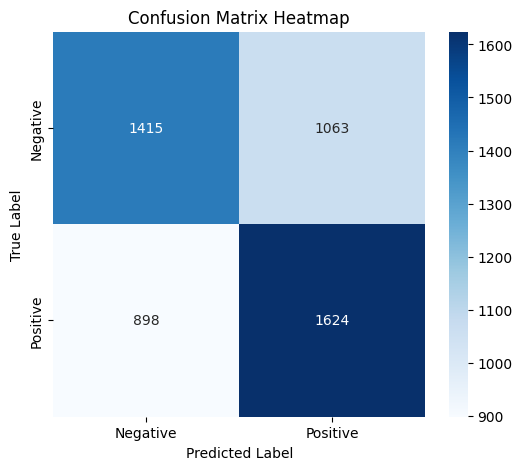

In [10]:
# Confusion Matrix를 Heatmap 그래프로 시각화, 테스트 데이터 평가 데이터를 활용
import matplotlib.pyplot as plt # 그래프 그리기 기본 라이브러리
import seaborn as sns # 시각화 스타일을 더 깔끔하게 만들어주는 라이브러리
import numpy as np # Confunsion Matrix 데이터를 배열 형태로 관리

# Confusion Matrix 데이터, 2x2 행렬 구조 실제 라벨과 예측 라벨의 매칭 결과
# cm = np.array([ [1562, 916],
#                [973, 1549] ])
cm = np.array(confusion_matrix(all_labels, all_preds))

# 클래스 이름
labels = ['Negative', 'Positive']

# Heatmap 시각화
plt.figure(figsize=(6, 5))
# cm 데이터, annot=True 각 셀에 숫자 표시, fmt='d' 정수 형태로 출력, cmap='Blues' 파란색 계열 색상 맵 선택, xticklabels/yticklabels 축 라벨에 클래스 이름 푝시
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
# 추론 함수

def predict(text, tokenizer, model, device):
    model.eval() # 검증/추론 모드 전환

    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True
    ).to(device)

    # 검증/추론시 미분 연산 하지 않음
    with torch.no_grad():
        # AMP(Automatic Mixed Precision) GPU에서 연산 속도와 메모리 효율 향상
        with autocast(device_type='cuda', dtype=torch.float16): # GPU에서 FP16 연산으로 추론
            outputs = model(**inputs) # 모델 예측
            pred = outputs.logits.argmax(dim=-1).item()
    return 'Positive' if pred == 1 else 'Negative'

# 추론 테스트
test_texts = [
    "I really love this movie, it was fantastic!",
    "This product is terrible and I will never buy it again.",
    "The service was okay, not too bad but not great either."
]
for text in test_texts:
    result = predict(text, tokenizer, model, device)
    print(f'Text: {text}\nPrediction: {result}\n')

Text: I really love this movie, it was fantastic!
Prediction: Positive

Text: This product is terrible and I will never buy it again.
Prediction: Positive

Text: The service was okay, not too bad but not great either.
Prediction: Negative



In [ ]:
# FastAPI 추론 서비스
# - /llm_app/transformer_classifier_sentiment_18_app.py
# - FastAPI 구동: 터미널에서 구동, uvicorn transformer_classifier_sentiment_18_app:app --reload
# - 윈도우 파워쉘: Invoke-RestMethod -Uri "http://127.0.0.1:8000/predict" -Method Post -ContentType "application/json" -Body '{"text":"I really love this movie, it was fantastic!"}'
# - Postman app
# - API 코드로 테스트: Python, Java...
import requests

url = "http://127.0.0.1:8000/predict"
data = {"text": "I really love this movie, it was fantastic!"}

response = requests.post(url, json=data)
print(response.json())

{'sentiment': 'Positive'}
